In [ ]:
import numpy as np
data = np.load(f"data/lego_200x200.npz")

# Training images: [100, 200, 200, 3]
images_train = data["images_train"] / 255.0

# Cameras for the training images 
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = data["c2ws_train"]

# Validation images: 
images_val = data["images_val"] / 255.0

# Cameras for the validation images: [10, 4, 4]
# (camera-to-world transformation matrix): [10, 200, 200, 3]
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering: 
# (camera-to-world transformation matrix): [60, 4, 4]
c2ws_test = data["c2ws_test"]

# Camera focal length
focal = data["focal"]  # float

In [ ]:
"""
[Impl] In this session you would need to implement a function x_w = transform(c2w, x_c) that transform a point from camera to the world space. You can verify your implementation by checking if the follow statement is always true: x == transform(c2w.inv(), transform(c2w, x)). Note you might want your implementation to support batched coordinates for later use. You can implement it with either numpy or torch. 
"""

def transform(c2w, x_c):
    """
    Args:
        c2w: [4, 4] or [B, 4, 4]
        x_c: [3] or [B, 3]
    Returns:
        x_w: [3] or [B, 3]
    """
    if c2w.ndim == 2:
        c2w = c2w[None]  # [1, 4, 4]
    if x_c.ndim == 1:
        x_c = x_c[None]  # [1, 3]
    B = c2w.shape[0]
    x_c_h = np.concatenate([x_c, np.ones((B, 1))], axis=-1)  # [B, 4]
    x_w_h = (c2w @ x_c_h[..., None])[..., 0]  # [B, 4]
    x_w = x_w_h[..., :3] / x_w_h[..., 3:]  # [B, 3]
    return x_w.squeeze()  # [3] or [B, 3]

"""
 [Impl] In this session you would need to implement a function that invert the aforementioned process, which transform a point from the pixel coordinate system back to the camera coordinate system: x_c = pixel_to_camera(K, uv, s). Similar to the previous session, you might also want your implementation here to support batched coordinates for later use. You can implement it with either numpy or torch. 
"""

def pixel_to_camera(K, uv, s):
    """
    Args:
        K: [3, 3] or [B, 3, 3]
        uv: [2] or [B, 2]
        s: scalar or [B, 1]
    Returns:
        x_c: [3] or [B, 3]
    """
    if K.ndim == 2:
        K = K[None]  # [1, 3, 3]
    if uv.ndim == 1:
        uv = uv[None]  # [1, 2]
    if np.isscalar(s):
        s = np.array([s])  # [1]
    if s.ndim == 1:
        s = s[:, None]  # [B, 1]
    B = K.shape[0]
    uv_h = np.concatenate([uv, np.ones((B, 1))], axis=-1)  # [B, 3]
    x_c = (np.linalg.inv(K) @ uv_h[..., None])[..., 0] * s[..., None]  # [B, 3]
    return x_c.squeeze()  # [3] or [B, 3]

"""
 [Impl] In this section you will need to implement a function that converts a pixel coordinate to a ray with origin and normalized direction: ray_o, ray_d = pixel_to_ray(K, c2w, uv). You might find your previously implemented functions useful here. Similarly, you might also want your implementation to support batched coordinates. """
def pixel_to_ray(K, c2w, uv):
    """
    Args:
        K: [3, 3] or [B, 3, 3]
        c2w: [4, 4] or [B, 4, 4]
        uv: [2] or [B, 2]
    Returns:
        ray_o: [3] or [B, 3]
        ray_d: [3] or [B, 3]
    """
    if K.ndim == 2:
        K = K[None]  # [1, 3, 3]
    if c2w.ndim == 2:
        c2w = c2w[None]  # [1, 4, 4]
    if uv.ndim == 1:
        uv = uv[None]  # [1, 2]
    B = K.shape[0]
    ray_o = c2w[..., :3, -1]  # [B, 3]
    ray_d = transform(c2w, pixel_to_camera(K, uv, s=1.0)) - ray_o  # [B, 3]
    ray_d = ray_d / np.linalg.norm(ray_d, axis=-1, keepdims=True)  # normalize
    return ray_o.squeeze(), ray_d.squeeze()  # [3] or [B, 3]

In [ ]:
"""
 [Impl: Sampling Rays from Images] In Part 1, we have done random sampling on a single image to get the pixel color and pixel coordinates. Here we can build on top of that, and with the camera intrinsics & extrinsics, we would be able to convert the pixel coordinates into ray origins and directions. Make sure to account for the offset from image coordinate to pixel center (this can be done simply by adding .5 to your UV pixel coordinate grid)! Since we have multiple images now, we have two options of sampling rays. Say we want to sample N rays at every training iteration, option 1 is to first sample M images, and then sample N // M rays from every image. The other option is to flatten all pixels from all images and do a global sampling once to get N rays from all images. You can choose which ever way do ray sampling. 
"""

# Flatten all pixels from all images and do a global sampling
import torch


def sample_rays(images, c2ws, focal, N):
    """
    Args:
        images: [N_images, H, W, 3]
        c2ws: [N_images, 4, 4]
        focal: float
        N: int
    Returns:
        ray_o: [N, 3]
        ray_d: [N, 3]
        rgb: [N, 3]
    """
    N_images, H, W, _ = images.shape
    K = np.array([[focal, 0, W / 2], [0, focal, H / 2], [0, 0, 1]])  # [3, 3]
    uv = np.random.rand(N) * np.array([W - 1, H - 1]) + 0.5  # [N, 2]
    img_indices = np.random.randint(0, N_images, size=N)  # [N]
    c2w = c2ws[img_indices]  # [N, 4, 4]
    ray_o, ray_d = pixel_to_ray(K[None], c2w, uv)  # [N, 3], [N, 3]
    rgb = images[img_indices, uv[:, 1].astype(int), uv[:, 0].astype(int)]  # [N, 3]
    return ray_o.squeeze(), ray_d.squeeze(), rgb.squeeze()  # [N, 3], [N, 3], [N, 3]

"""
 [Impl: Sampling Points along Rays.] After having rays, we also need to discritize each ray into samples that live in the 3D space. The simplist way is to uniformly create some samples along the ray (t = np.linspace(near, far, n_samples)). For the lego scene that we have, we can set near=2.0 and far=6.0. The actually 3D corrdinates can be accquired by x = R_0 + R_d * t. However this would lead to a fixed set of 3D points, which could potentially lead to overfitting when we train the NeRF later on. On top of this, we want to introduce some small perturbation to the points only during training, so that every location along the ray would be touched upon during training. this can be achieved by something like t = t + (np.random.rand(t.shape) * t_width) where t is set to be the start of each interval. We recommend to set n_samples to 32 or 64 in this project. 
"""

def sample_along_rays(rays_o, rays_d, near=2.0, far=6.0, n_samples=32, perturb=True, use_torch=False):
    """
    Args:
        rays_o: [N, 3]
        rays_d: [N, 3]
        near: float
        far: float
        n_samples: int
        perturb: bool
    Returns:
        points: [N, n_samples, 3]
    """
    if use_torch:
        t = torch.linspace(near, far, n_samples).to(rays_o.device)  # [n_samples]
    else:
        t = np.linspace(near, far, n_samples)  # [n_samples]
    if perturb:
        if use_torch:
            t += (torch.rand_like(t) - 0.5) * (far - near) / n_samples  # perturb
        else:
            t += (np.random.rand(*t.shape) - 0.5) * (far - near) / n_samples  # perturb
    points = rays_o[:, None] + rays_d[:, None] * t[None, :, None]  # [N, n_samples, 3]
    return points.squeeze()  # [N, n_samples, 3]

In [ ]:
import torch
from tqdm import tqdm
class RaysData(torch.utils.data.Dataset):
    def __init__(self, images, K, c2ws):
        self.images = images
        self.K = K
        self.c2ws = c2ws
        self.N_images, self.H, self.W, _ = images.shape
        self.N_pixels = self.N_images * self.H * self.W
        
        # Precompute self.rays_o, self.rays_d, self.uvs, self.pixels. Keep as numpy arrays for now, convert to torch tensors in __getitem__
        self.rays_o = []
        self.rays_d = []
        self.uvs = []
        self.pixels = []
        for img_idx in tqdm(range(self.N_images)):
            c2w = self.c2ws[img_idx]
            for v in range(self.H):
                for u in range(self.W):
                    uv = np.array([u + 0.5, v + 0.5], dtype=np.float32)
                    ray_o, ray_d = pixel_to_ray(self.K, c2w, uv)
                    self.rays_o.append(ray_o)
                    self.rays_d.append(ray_d)
                    self.uvs.append(np.array([u, v], dtype=np.int32))
                    self.pixels.append(self.images[img_idx, v, u])
        self.rays_o = np.array(self.rays_o)  # [N_pixels, 3]
        self.rays_d = np.array(self.rays_d)  # [N_pixels, 3]
        self.uvs = np.array(self.uvs)  # [N_pixels, 2]
        self.pixels = np.array(self.pixels)  # [N_pixels, 3]

    def __len__(self):
        return self.N_pixels
    def __getitem__(self, idx):
        ray_o = torch.from_numpy(self.rays_o[idx]).float()
        ray_d = torch.from_numpy(self.rays_d[idx]).float()
        rgb = torch.from_numpy(self.pixels[idx]).float()
        return ray_o, ray_d, rgb

    def sample_rays(self, N):
        """Sample N rays from the dataset. Returns ray origins, directions, and RGB values."""
        indices = torch.randperm(self.N_pixels)[:N]
        ray_o, ray_d, rgb = zip(*[self[i] for i in indices])
        return torch.stack(ray_o), torch.stack(ray_d), torch.stack(rgb)


In [ ]:
import viser, time  # pip install viser
import numpy as np

# --- You Need to Implement These ------
K = np.array([[focal, 0, images_train.shape[2] / 2], [0, focal, images_train.shape[1] / 2], [0, 0, 1]])  # [3, 3]
dataset = RaysData(images_train, K, c2ws_train)
rays_o, rays_d, pixels = dataset.sample_rays(100) # Should expect (B, 3)
points = sample_along_rays(rays_o, rays_d, perturb=True)
H, W = images_train.shape[1:3]
points = points.numpy()
# ---------------------------------------

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
    server.add_camera_frustum(
        f"/cameras/{i}",
        fov=2 * np.arctan2(H / 2, K[0, 0]),
        aspect=W / H,
        scale=0.15,
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
        position=c2w[:3, 3],
        image=image
    )
for i, (o, d) in enumerate(zip(rays_o, rays_d)):
    server.add_spline_catmull_rom(
        f"/rays/{i}", positions=np.stack((o, o + d * 6.0)),
    )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points).reshape(-1, 3),
    points=points.reshape(-1, 3),
    point_size=0.02,
)

while True:
    time.sleep(0.1)  # Wait to allow visualization to run



100%|██████████| 100/100 [01:34<00:00,  1.05it/s]
/tmp/ipykernel_28102/3358199715.py:55: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  points = rays_o[:, None] + rays_d[:, None] * t[None, :, None]  # [N, n_samples, 3]


╭────── viser (listening *:8080) ───────╮
│             ╷                         │
│   HTTP      │ http://localhost:8080   │
│   Websocket │ ws://localhost:8080     │
│             ╵                         │
╰───────────────────────────────────────╯

(viser) Share URL requested!

(viser) Generated share URL (expires in 24 hours, max 16 clients): https://raster-shadow.share.viser.studio

/tmp/ipykernel_28102/1508355025.py:15: DeprecationWarning: ViserServer.add_camera_frustum has been deprecated, use ViserServer.scene.add_camera_frustum instead. Alternatively, pin to `viser<0.2.0`.
  server.add_camera_frustum(
/tmp/ipykernel_28102/1508355025.py:25: DeprecationWarning: ViserServer.add_spline_catmull_rom has been deprecated, use ViserServer.scene.add_spline_catmull_rom instead. Alternatively, pin to `viser<0.2.0`.
  server.add_spline_catmull_rom(
/tmp/ipykernel_28102/1508355025.py:28: DeprecationWarning: ViserServer.add_point_cloud has been deprecated, use ViserServer.scene.add_point_cloud instead. Alternatively, pin to `viser<0.2.0`.
  server.add_point_cloud(


(viser) Disconnected from share URL

opening handshake failed
Traceback (most recent call last):
  File "/home/yifan/cs180/.conda/lib/python3.11/site-packages/websockets/http11.py", line 138, in parse
    request_line = yield from parse_line(read_line)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yifan/cs180/.conda/lib/python3.11/site-packages/websockets/http11.py", line 309, in parse_line
    line = yield from read_line(MAX_LINE_LENGTH)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yifan/cs180/.conda/lib/python3.11/site-packages/websockets/streams.py", line 46, in read_line
    raise EOFError(f"stream ends after {p} bytes, before end of line")
EOFError: stream ends after 0 bytes, before end of line

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/yifan/cs180/.conda/lib/python3.11/site-packages/websockets/server.py", line 545, in parse
    request = yield from Request.parse(
              ^^^^^^^^^^^^^^^^^^^^^^^^^


KeyboardInterrupt: 

In [15]:
# Visualize Cameras, Rays and Samples
import viser, time
import numpy as np

# --- You Need to Implement These ------
dataset = RaysData(images_train, K, c2ws_train)

# This will check that your uvs aren't flipped
uvs_start = 0
uvs_end = 40_000
sample_uvs = dataset.uvs[uvs_start:uvs_end] # These are integer coordinates of widths / heights (xy not yx) of all the pixels in an image
print(type(sample_uvs[0]))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:35<00:00,  1.05it/s]

<class 'numpy.ndarray'>


In [ ]:
# uvs are array of xy coordinates, so we need to index into the 0th image tensor with [0, height, width], so we need to index with uv[:,1] and then uv[:,0]
sample_uvs[:,1], sample_uvs[:,0]
images_train[0, sample_uvs[:,1], sample_uvs[:,0]]
assert np.all(images_train[0, sample_uvs[:,1], sample_uvs[:,0]] == dataset.pixels[uvs_start:uvs_end])
H, W = images_train.shape[1:3]

# # Uncoment this to display random rays from the first image
# indices = np.random.randint(low=0, high=40_000, size=100)

# # Uncomment this to display random rays from the top left corner of the image
indices_x = np.random.randint(low=100, high=200, size=100)
indices_y = np.random.randint(low=0, high=100, size=100)
indices = indices_x + (indices_y * 200)

data = {"rays_o": dataset.rays_o[indices], "rays_d": dataset.rays_d[indices]}
points = sample_along_rays(data["rays_o"], data["rays_d"])
# ---------------------------------------

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
  server.add_camera_frustum(
    f"/cameras/{i}",
    fov=2 * np.arctan2(H / 2, K[0, 0]),
    aspect=W / H,
    scale=0.15,
    wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
    position=c2w[:3, 3],
    image=image
  )
for i, (o, d) in enumerate(zip(data["rays_o"], data["rays_d"])):
  positions = np.stack((o, o + d * 6.0))
  server.add_spline_catmull_rom(
      f"/rays/{i}", positions=positions,
  )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points).reshape(-1, 3),
    points=points.reshape(-1, 3),
    point_size=0.03,
)

while True:
    time.sleep(0.1)  # Wait to allow visualization to run

In [6]:
"""
 [Impl: Network] After having samples in 3D, we want to use the network to predict the density and color for those samples in 3D. So you would create a MLP that is similar to Part 1, but with three changes:

    Input is now 3D world coordinates instead of 2D pixel coordinates, along side a 3D vector as the ray direction. And we are going to output not only the color, but also the density for the 3D points. In the radiance field, the color of each point depends on the view direction, so we are going to use the view direction as the condition when we predict colors. Note we use Sigmoid to constrain the output color within range (0, 1), and use ReLU to constrain the output density to be positive. The ray direction also needs to be encoded by positional encoding (PE) but can use less frequency (e.g., L=4) than the cooridnate PE (e.g., L=10).
    Make the MLP deeper. We are now doing a more challenging task of optimizing a 3D representation instead of 2D. So we need a more powerful network.
    Inject the input (after PE) to the middle of your MLP through concatenation. It's a general trick for deep neural network, that is helpful for it to not forgetting about the input.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    """
    Implements the PE (Positional Encoding) block shown in the diagram.
    """
    def __init__(self, num_freqs, include_input=True):
        super().__init__()
        self.include_input = include_input
        self.freq_bands = 2.0 ** torch.linspace(0.0, num_freqs - 1, num_freqs)

    def forward(self, x):
        # x shape: [batch_size, 3]
        embeds = [x] if self.include_input else []
        for freq in self.freq_bands:
            embeds.append(torch.sin(x * freq * 3.14159)) # Using Pi
            embeds.append(torch.cos(x * freq * 3.14159))
        
        # Concatenate all frequencies
        return torch.cat(embeds, dim=-1)

class NeRF(nn.Module):
    def __init__(self, D=8, W=256, L_x=10, L_d=4, skip_layer=4):
        """
        D: Depth of the backbone (default 8 layers)
        W: Width of the backbone (default 256 channels)
        L_x: Frequency bands for spatial input x (leads to input size 63 if include_input=True)
        L_d: Frequency bands for direction r_d (leads to input size 27 if include_input=True)
        skip_layer: The index of the layer to add the skip connection (default index 4, i.e., 5th layer)
        """
        super().__init__()
        self.skip_layer = skip_layer
        
        # --- 1. Positional Encodings (PE) ---
        # Input x is 3D -> PE -> 3 + 2 * 3 * 10 = 63 channels
        self.pe_x = PositionalEncoding(num_freqs=L_x, include_input=True)
        input_ch_x = 3 + 3 * 2 * L_x
        
        # Input r_d is 3D -> PE -> 3 + 2 * 3 * 4 = 27 channels
        self.pe_d = PositionalEncoding(num_freqs=L_d, include_input=True)
        input_ch_d = 3 + 3 * 2 * L_d

        # --- 2. Main Backbone (8 Layers) ---
        self.layers = nn.ModuleList()
        
        for i in range(D):
            if i == 0:
                # First layer takes encoded x
                layer = nn.Linear(input_ch_x, W)
            elif i == skip_layer:
                # Skip connection: concat input x again
                layer = nn.Linear(W + input_ch_x, W)
            else:
                # Standard layer
                layer = nn.Linear(W, W)
            self.layers.append(layer)

        # --- 3. Density Head (Top Branch) ---
        # Based on diagram: Backbone -> Linear(1) -> ReLU -> Density
        self.density_layer = nn.Linear(W, 1)
        
        # --- 4. Color Head (Bottom Branch) ---
        # Based on diagram: Backbone -> Linear(256) -> Concat(r_d) -> Linear(128) -> Linear(3)
        
        # The projection layer before concatenation
        self.feature_layer = nn.Linear(W, 256) 
        
        # The layer processing features + viewing direction
        self.color_layer_1 = nn.Linear(256 + input_ch_d, 128)
        
        # The final output layer
        self.color_layer_2 = nn.Linear(128, 3)

    def forward(self, x, r_d):
        """
        x: Spatial inputs [batch_size, 3]
        r_d: Viewing direction inputs [batch_size, 3]
        """
        # 1. Apply Positional Encoding
        x_embed = self.pe_x(x)      # Shape: [B, 63]
        d_embed = self.pe_d(r_d)    # Shape: [B, 27]
        # 2. Pass through Backbone
        h = x_embed
        for i, layer in enumerate(self.layers):
            h = layer(h)
            h = F.relu(h)
            
            # Apply skip connection at the specified layer
            if i == self.skip_layer - 1: # If we just finished layer 4 (index 3), prepare next input
                pass # Logic handled in next iteration input, but we need to store logic for next loop
            
            # Prepare input for next layer (checking if next layer needs skip)
            if i + 1 == self.skip_layer:
                h = torch.cat([h, x_embed], dim=-1)

        # 3. Output Density (Top Branch)
        # Diagram: Linear(1) -> ReLU -> Density
        density = self.density_layer(h)
        density = F.relu(density) 

        # 4. Output Color (Bottom Branch)
        # Diagram: Linear(256) (No explicit ReLU shown on this specific block, but usually implied)
        feat = self.feature_layer(h)
        
        # Concatenate with Direction PE
        # Diagram: Concat symbol combining 'feat' and 'd_embed'
        feat_view = torch.cat([feat, d_embed], dim=-1)
        
        # Diagram: Linear(128) -> ReLU
        rgb_h = self.color_layer_1(feat_view)
        rgb_h = F.relu(rgb_h)
        
        # Diagram: Linear(3) -> Sigmoid -> RGB
        rgb = self.color_layer_2(rgb_h)
        rgb = torch.sigmoid(rgb)

        return rgb, density

In [7]:
# Volume Rendering (PyTorch version)

def volrend(sigmas, rgbs, step_size, return_weights=False):
    """
    PyTorch implementation of volume rendering that supports backprop.
    Volume rendering equation for a batch of samples along a ray.

    Args:
        sigmas: Tensor or array-like with shape [N, S, 1] or [S, 1] (density per sample)
        rgbs: Tensor or array-like with shape [N, S, 3] or [S, 3] (color per sample)
        step_size: float - distance between samples along the ray
        return_weights: bool - if True return (pixel_colors, weights) where weights shape is [N, S]

    Returns:
        pixel_colors: Tensor [N, 3] - final rendered pixel colors
        (optional) weights: Tensor [N, S] - compositing weights for each sample
    """
    import torch

    # convert to tensors
    sigmas = torch.as_tensor(sigmas)
    rgbs = torch.as_tensor(rgbs)

    # Ensure float dtype
    sigmas = sigmas.to(dtype=torch.float32)
    rgbs = rgbs.to(dtype=torch.float32)

    # Normalize dims to batch-first: [N, S, 1] and [N, S, 3]
    if sigmas.dim() == 2:
        sigmas = sigmas.unsqueeze(0)  # [1, S, 1]
    if rgbs.dim() == 2:
        rgbs = rgbs.unsqueeze(0)  # [1, S, 3]

    N, S = sigmas.shape[:2]
    sigmas = sigmas.squeeze(-1)  # [N, S]
    device = sigmas.device

    # Compute alpha: alpha = 1 - exp(-sigma * delta)
    # Use torch.exp so gradients flow
    alphas = 1.0 - torch.exp(-sigmas * float(step_size))  # [N, S]

    # Transmittance before each sample: T_i = prod_{j < i} (1 - alpha_j)
    # Compute one_minus_alpha = exp(-sigma * delta) which is numerically stable
    one_minus_alpha = torch.exp(-sigmas * float(step_size))  # [N, S]

    # Cumulative product along samples
    # cprod[:, i] = prod_{j=0..i} one_minus_alpha[:, j]
    cprod = torch.cumprod(one_minus_alpha, dim=1)

    # trans_before: shift right and prepend ones
    ones = torch.ones((N, 1), dtype=sigmas.dtype, device=device)
    trans_before = torch.cat([ones, cprod[:, :-1]], dim=1)  # [N, S]

    # Weights
    weights = trans_before * alphas  # [N, S]

    # Composite color
    pixel_colors = torch.sum(weights.unsqueeze(-1) * rgbs, dim=1)  # [N, 3]

    if return_weights:
        return pixel_colors, weights
    return pixel_colors


In [8]:
import torch
torch.manual_seed(42)
sigmas = torch.rand((10, 64, 1))
rgbs = torch.rand((10, 64, 3))
step_size = (6.0 - 2.0) / 64
rendered_colors = volrend(sigmas, rgbs, step_size)

correct = torch.tensor([
    [0.5006, 0.3728, 0.4728],
    [0.4322, 0.3559, 0.4134],
    [0.4027, 0.4394, 0.4610],
    [0.4514, 0.3829, 0.4196],
    [0.4002, 0.4599, 0.4103],
    [0.4471, 0.4044, 0.4069],
    [0.4285, 0.4072, 0.3777],
    [0.4152, 0.4190, 0.4361],
    [0.4051, 0.3651, 0.3969],
    [0.3253, 0.3587, 0.4215]
  ])
assert torch.allclose(rendered_colors, correct, rtol=1e-4, atol=1e-4)



In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def render(model, c2w, K, show=False, near=2.0, far=6.0):
    """
    Render a novel view given a NeRF model and a camera-to-world matrix.
    Args:
        model: NeRF model
        c2w: [4, 4] camera-to-world transformation matrix
    Returns:
        image: [H, W, 3] rendered image
    """
    H, W = images_train.shape[1:3]
    
    points = []
    rays_o = []
    rays_d = []
    for u in range(H):
        for v in range(W):
            uv = np.array([u + 0.5, v + 0.5], dtype=np.float32)
            ray_o, ray_d = pixel_to_ray(K, c2w, uv)
            rays_o.append(ray_o)
            rays_d.append(ray_d)

    rays_o = np.array(rays_o)  # [H*W, 3]
    rays_d = np.array(rays_d)  # [H*W, 3]
    points = sample_along_rays(rays_o, rays_d, near=near, far=far, perturb=False)  # [H*W, n_samples, 3]
    
    # ray_dirs need to be repeated 32x for each point
    ray_dirs = np.array(rays_d)  # [H*W, 3]
    ray_dirs = np.repeat(ray_dirs[:, None, :], points.shape[1], axis=1)  # [H*W, n_samples, 3]
    points = torch.from_numpy(np.array(points)).float()  # [H*W, n_samples, 3]
    ray_dirs = torch.from_numpy(np.array(ray_dirs)).float()  # [H*W, n_samples, 3]
    ray_dirs = ray_dirs / torch.norm(ray_dirs, dim=-1, keepdim=True)  # Normalize ray directions
    ray_dirs_flat = ray_dirs.view(-1, 3)  # [H*W*n_samples, 3]
    points_flat = points.view(-1, 3)  # [H*W*n_samples, 3]
    # Predict colors and densities from the model
    with torch.no_grad():
        rgbs_flat, sigmas_flat = model(points_flat.to(device), ray_dirs_flat.to(device))
    
    rgbs_flat = rgbs_flat.cpu().numpy()  # [H*W*n_samples, 3]
    sigmas_flat = sigmas_flat.cpu().numpy()  # [H*W*n_samples, 1]

    # Reshape back to [H*W, n_samples]
    rgbs = rgbs_flat.reshape(points.shape[0], points.shape[1], 3)
    sigmas = sigmas_flat.reshape(points.shape[0], points.shape[1], 1)
    step_size = (6.0 - 2.0) / points.shape[1]
    # Perform volume rendering
    pixel_colors = volrend(sigmas, rgbs, step_size)  # [H*W, 3]
    image = pixel_colors.reshape(H, W, 3)  # [H, W, 3]
    if show:
        plt.imshow(image)
        plt.axis('off')
        plt.show()

    return image

In [ ]:
#  [Deliverables] As a reference, the images below show the process of optimizing the network to fit on our lego multi-view images from a novel view. The staff solution reaches above 23 PSNR with 1000 gradient steps and a batchsize of 10K rays per gradent step. The staff solution uses an Adam optimizer with a learning rate of 5e-4. For guaranteed full credit, achieve 23 PSNR for any number of iterations. 
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math
import torch.optim as optim


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(model, dataset, num_iterations=1501, batch_size=10000, progression_cam=None, show_psnr_curve=False, val_dataset=None, show_train_loss=False, im_name=None, verbose=False, num_samples=32, near=2.0, far=6.0):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    psnr_values = []
    train_loss = []
    progression_images = []
    val_psnr = []
    model.to(device)
    for iteration in tqdm(range(num_iterations)):
        rays_o, rays_d, pixels = dataset.sample_rays(batch_size)
        rays_o, rays_d, pixels = rays_o.to(device), rays_d.to(device), pixels.to(device)
        points = sample_along_rays(rays_o, rays_d, 
                                   near=near, far=far,
                                   n_samples=num_samples,perturb=True, use_torch=True)
        points = points.to(device)

        view_dirs = rays_d.unsqueeze(1).expand(-1, num_samples, -1)
        view_dirs = view_dirs / torch.norm(view_dirs, dim=-1, keepdim=True)
        view_dirs = view_dirs.to(device)
        pred_rgb, pred_density = model(points.view(-1, 3), view_dirs.view(-1, 3))
        pred_rgb = pred_rgb.view(batch_size, -1, 3)
        pred_density = pred_density.view(batch_size, -1, 1)
        step_size = (6.0 - 2.0) / pred_rgb.shape[1]
        pred_rgb = volrend(pred_density, pred_rgb, step_size)
        loss = criterion(pred_rgb, pixels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        mse = loss.item()
        psnr = -10.0 * math.log10(mse) * 23/20

        if iteration % 100 == 0 and verbose:
            print(f'Iteration {iteration}, MSE: {mse:.6f}, PSNR: {psnr:.2f} dB')
        if progression_cam is not None:
            step = max(1, num_iterations // 4)
            if iteration % step == 0 or iteration == num_iterations - 1:
                # Render the validation image
                img = render(model, progression_cam, K, show=True, near=near, far=far)
                progression_images.append((iteration, img))

        if show_psnr_curve:
            psnr_values.append(psnr)

        if val_dataset and iteration % 100 == 0:
            val_psnr.append(validate(model, val_dataset=val_dataset))
            model.train()
            if verbose:
                print(f'Validation PSNR at iteration {iteration}: {val_psnr[-1]:.2f} dB')

    if progression_cam is not None:
        fig, axes = plt.subplots(1, len(progression_images), figsize=(15, 5))
        for ax, (iteration, img) in zip(axes, progression_images):
            ax.imshow(img)
            ax.set_title(f'Iteration {iteration}')
            ax.axis('off')
        plt.savefig("out/2/" + im_name + "_progressions.png")
        plt.show()

    if show_psnr_curve:
        if val_dataset:
            plt.plot(np.arange(0, num_iterations, 100), val_psnr, label='Validation PSNR', marker='o')
            plt.legend()
        plt.plot(psnr_values, label='Training PSNR')
        plt.title('PSNR Curve')
        plt.xlabel('Iteration (x100)')
        plt.ylabel('PSNR (dB)')

        plt.savefig("out/2/" + im_name + "_psnr.png")
        plt.show()

    if show_train_loss:
        plt.plot(train_loss)
        plt.title('Training Loss Curve')
        plt.xlabel('Iteration')
        plt.ylabel('MSE Loss')
        plt.savefig("out/2/" + im_name + "_train_loss.png")
        plt.show()

def validate(model, val_dataset, num_samples=32):
    model.eval()
    n_pix = val_dataset.H * val_dataset.W
    with torch.no_grad():
        psnr_values = []
        for i in range(len(val_dataset) // n_pix):
            ray_o, ray_d, pixel = val_dataset[i * n_pix:(i + 1) * n_pix]
            ray_o, ray_d, pixel = ray_o.to(device), ray_d.to(device), pixel.to(device)
            points = sample_along_rays(ray_o, ray_d, perturb=False, use_torch=True)
            points = points.to(device)
            view_dirs = ray_d.unsqueeze(1).expand(-1, num_samples, -1)
            view_dirs = view_dirs / torch.norm(view_dirs, dim=-1, keepdim=True)
            view_dirs = view_dirs.to(device)

            pred_rgb, pred_density = model(points.view(-1, 3), view_dirs.view(-1, 3)) # [40000*32, 3], [40000*32, 1]
            step_size = (6.0 - 2.0) / pred_rgb.shape[1]
            
            pred_rgb = pred_rgb.view(n_pix, -1, 3)
            pred_density = pred_density.view(n_pix, -1, 1)
            pred_rgb = volrend(pred_density, pred_rgb, step_size)
            mse = F.mse_loss(pred_rgb, pixel).item()
            psnr = -10.0 * math.log10(mse + 1e-8) * 23/20
            psnr_values.append(psnr)
    avg_psnr = sum(psnr_values) / len(psnr_values)
    return avg_psnr

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

Iteration 0, MSE: 0.064635, PSNR: 13.68 dB


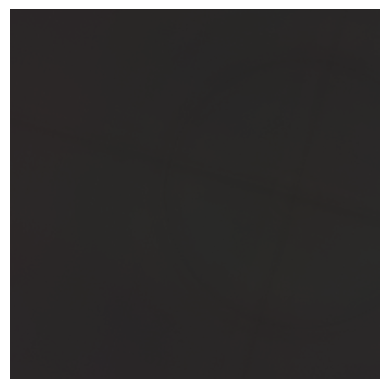

  0%|          | 1/1001 [00:03<50:54,  3.05s/it]

Validation PSNR at iteration 0: 8.08 dB


 10%|▉         | 100/1001 [00:32<04:35,  3.27it/s]

Iteration 100, MSE: 0.019515, PSNR: 19.66 dB


 10%|█         | 101/1001 [00:34<11:57,  1.25it/s]

Validation PSNR at iteration 100: 16.34 dB


 20%|█▉        | 200/1001 [01:04<04:19,  3.09it/s]

Iteration 200, MSE: 0.014258, PSNR: 21.23 dB


 20%|██        | 201/1001 [01:06<10:53,  1.22it/s]

Validation PSNR at iteration 200: 18.83 dB


 25%|██▍       | 250/1001 [01:21<03:41,  3.39it/s]

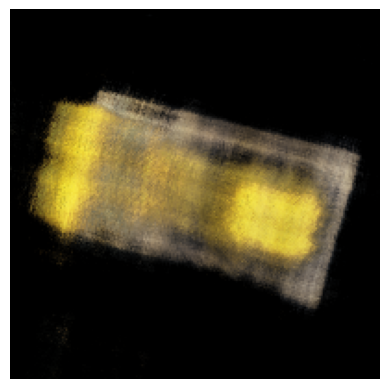

 30%|██▉       | 300/1001 [01:37<03:22,  3.46it/s]

Iteration 300, MSE: 0.011819, PSNR: 22.17 dB


 30%|███       | 301/1001 [01:39<09:51,  1.18it/s]

Validation PSNR at iteration 300: 19.92 dB


 40%|███▉      | 400/1001 [02:08<02:57,  3.38it/s]

Iteration 400, MSE: 0.010157, PSNR: 22.92 dB


 40%|████      | 401/1001 [02:10<07:55,  1.26it/s]

Validation PSNR at iteration 400: 20.94 dB


 50%|████▉     | 500/1001 [02:40<02:36,  3.20it/s]

Iteration 500, MSE: 0.009878, PSNR: 23.06 dB


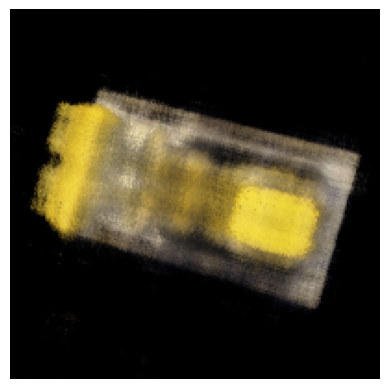

 50%|█████     | 501/1001 [02:43<09:39,  1.16s/it]

Validation PSNR at iteration 500: 21.39 dB


 60%|█████▉    | 600/1001 [03:13<01:53,  3.53it/s]

Iteration 600, MSE: 0.008857, PSNR: 23.61 dB


 60%|██████    | 601/1001 [03:15<05:35,  1.19it/s]

Validation PSNR at iteration 600: 21.92 dB


 70%|██████▉   | 700/1001 [03:44<01:29,  3.37it/s]

Iteration 700, MSE: 0.009424, PSNR: 23.30 dB


 70%|███████   | 701/1001 [03:46<03:58,  1.26it/s]

Validation PSNR at iteration 700: 22.39 dB


 75%|███████▍  | 750/1001 [04:01<01:07,  3.70it/s]

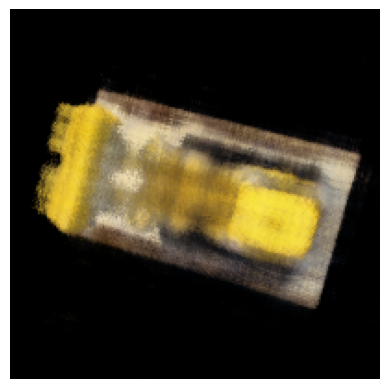

 80%|███████▉  | 800/1001 [04:17<01:05,  3.08it/s]

Iteration 800, MSE: 0.008192, PSNR: 24.00 dB


 80%|████████  | 801/1001 [04:19<02:42,  1.23it/s]

Validation PSNR at iteration 800: 23.24 dB


 90%|████████▉ | 900/1001 [04:49<00:28,  3.54it/s]

Iteration 900, MSE: 0.008678, PSNR: 23.71 dB


 90%|█████████ | 901/1001 [04:51<01:23,  1.19it/s]

Validation PSNR at iteration 900: 23.08 dB


100%|█████████▉| 1000/1001 [05:21<00:00,  3.40it/s]

Iteration 1000, MSE: 0.007969, PSNR: 24.13 dB


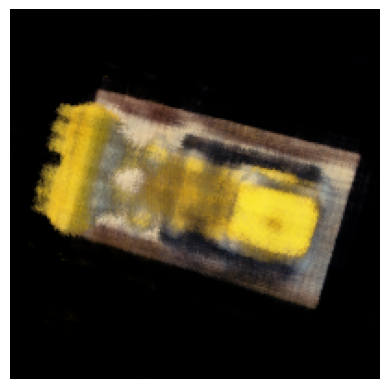

100%|██████████| 1001/1001 [05:24<00:00,  3.08it/s]

Validation PSNR at iteration 1000: 22.86 dB


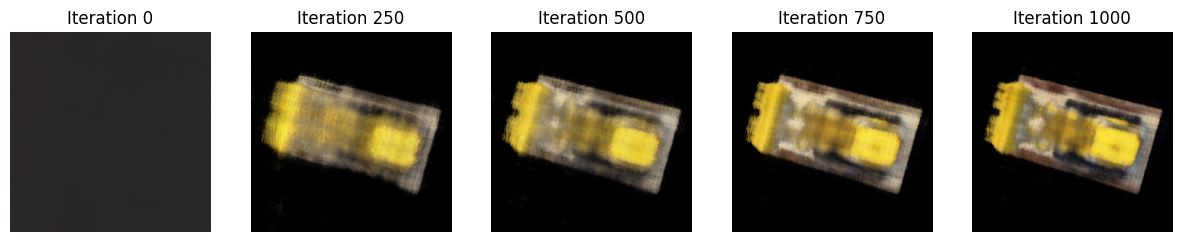

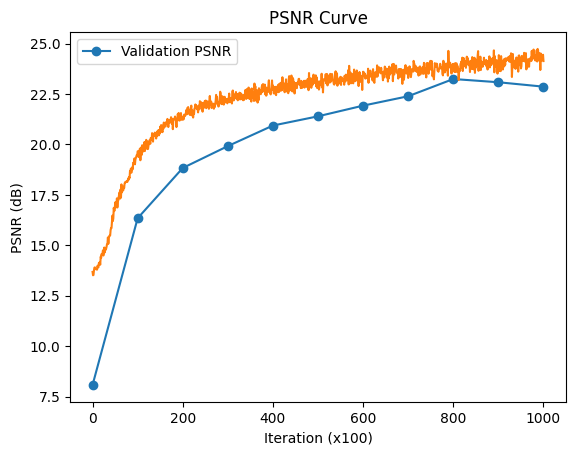

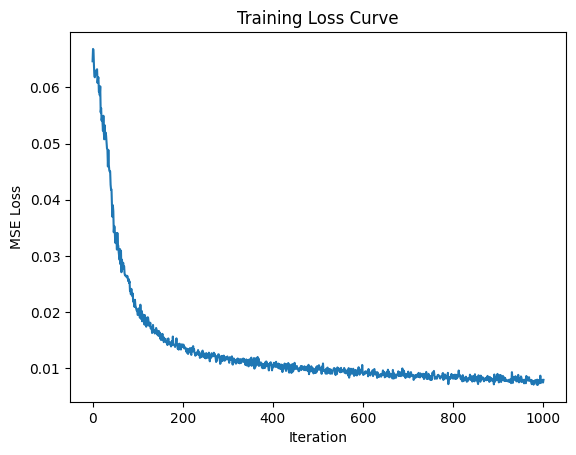

100%|██████████| 60/60 [01:07<00:00,  1.12s/it]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 200) to (208, 208) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [196]:
model = NeRF().to(device)
# add 5 copies of val to train set
combined_im = np.concatenate((images_train, np.repeat(images_val, 2, axis=0)), axis=0)
combined_c2ws = np.concatenate((c2ws_train, np.repeat(c2ws_val, 2, axis=0)), axis=0)
dataset = RaysData(combined_im, K, combined_c2ws)
val_dataset = val_dataset or RaysData(images_val, K, c2ws_val)
validate(model, val_dataset)
train(model=model, dataset=dataset, num_iterations=1001, batch_size=10000, progression_cam=c2ws_val[0], show_psnr_curve=True, val_dataset=val_dataset, show_train_loss=True, im_name="lego", verbose=True)

# render...
import imageio
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create video
frames = []
for i in tqdm(range(len(c2ws_test))):
    img = render(model, c2ws_test[i], K)
    # rotate im 90 degrees clockwise
    img = (img * 255).cpu().numpy().astype(np.uint8)
    img = np.rot90(img, k=-1)
    frames.append(img)

imageio.mimwrite('out/2/lego_spherical.mp4', frames, fps=30)

In [35]:
import numpy as np
data = np.load(f"data/lafufu_dataset.npz")
# Training images: [100, 200, 200, 3]
images_train = data["images_train"] / 255.0

# Cameras for the training images 
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = data["c2ws_train"]

# Validation images: 
images_val = data["images_val"] / 255.0

# Cameras for the validation images: [10, 4, 4]
# (camera-to-world transformation matrix): [10, 200, 200, 3]
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering: 
# (camera-to-world transformation matrix): [60, 4, 4]
#c2ws_test = data["c2ws_test"]

# Camera focal length
if "focal" in data:
    focal = data["focal"]  # float
    K = np.array([[focal, 0, images_train.shape[2] / 2], [0, focal, images_train.shape[1] / 2], [0, 0, 1]])  # [3, 3]
else:
    K = data["K"]
K

array([[210.82792084,   0.        , 133.14281503],
       [  0.        , 212.44367189,  98.507904  ],
       [  0.        ,   0.        ,   1.        ]])

  0%|          | 0/3001 [00:00<?, ?it/s]

Iteration 0, MSE: 0.302379, PSNR: 5.97 dB


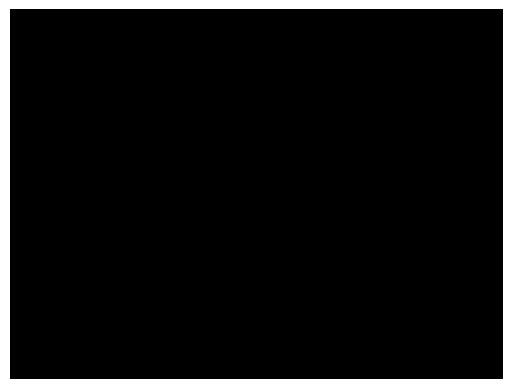

  0%|          | 1/3001 [00:04<3:47:51,  4.56s/it]

Validation PSNR at iteration 0: 5.65 dB


  3%|▎         | 100/3001 [00:42<19:15,  2.51it/s]

Iteration 100, MSE: 0.299607, PSNR: 6.02 dB


  3%|▎         | 101/3001 [00:45<53:45,  1.11s/it]

Validation PSNR at iteration 100: 5.65 dB


  4%|▍         | 133/3001 [00:57<18:46,  2.55it/s]

In [ ]:
model = NeRF().to(device)
# add 5 copies of val to train set
dataset = dataset or RaysData(images_train, K, c2ws_train)
val_dataset = val_dataset or RaysData(images_val, K, c2ws_val)
validate(model, val_dataset)
train(model=model, dataset=dataset, num_iterations=3001, batch_size=10000, progression_cam=c2ws_val[0], show_psnr_curve=True, val_dataset=val_dataset, show_train_loss=True, im_name="lafufu", verbose=True, num_samples=64, near=0.02, far=0.5)

# render...
import imageio
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def look_at_origin(pos):
  # Camera looks towards the origin
  forward = -pos / np.linalg.norm(pos)  # Normalize the direction vector

  # Define up vector (assuming y-up)
  up = np.array([0, 1, 0])

  # Compute right vector using cross product
  right = np.cross(up, forward)
  right = right / np.linalg.norm(right)

  # Recompute up vector to ensure orthogonality
  up = np.cross(forward, right)

  # Create the camera-to-world matrix
  c2w = np.eye(4)
  c2w[:3, 0] = right
  c2w[:3, 1] = up
  c2w[:3, 2] = forward
  c2w[:3, 3] = pos

  return c2w

def rot_x(phi):
    return np.array([
        [math.cos(phi), -math.sin(phi), 0, 0],
        [math.sin(phi), math.cos(phi), 0, 0],
        [0,0,1,0],
        [0,0,0,1],
    ])

# TODO: Change start position to a good position for your scene such as 
# the translation vector of one of your training camera extrinsics
START_POS = np.array([1., 0., 0.])
NUM_SAMPLES = 60

frames = []
for phi in tqdm(np.linspace(360., 0., NUM_SAMPLES, endpoint=False)):
    c2w = look_at_origin(START_POS)
    extrinsic = rot_x(phi/180.*np.pi) @ c2w
    
    # Generate view for this camera pose
    # TODO: Add code for generating a view with your model from the current extrinsic
    frame = render(model, extrinsic, K, near=0.02, far=0.5)
    frames.append(frame)

# Save video
import imageio
imageio.mimwrite('out/2/my_data_orbit.mp4', frames, fps=30)

  0%|          | 0/60 [00:00<?, ?it/s]

 10%|█         | 6/60 [00:10<01:36,  1.79s/it]


KeyboardInterrupt: 